# Deep learning for medical imaging

==============================================================================================
## Practicum 2: Computed Tomography Image Reconstruction
==============================================================================================

In this practicum, you will (1) simulate a simple phantom slice image, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over an slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms.  

### Aims:
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

In [6]:
%matplotlib inline

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

### 2.1 Create a simple and homogeneous phantom (1.5 points)

Create a 2D simple phantom which contains a fake lesion as shown below:

<img src='docs/images_4_notebook/SimplePhantom.png' width="200">

- Phantom size: 256 x 256 pixels.
- Phantom must contain 3 tissues:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom.

Once constructed, plot the original phantom and a pixel intensity (horizontal) profile along the lesion. Always remember to include the units of the axis when ploting a graph.

In [64]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

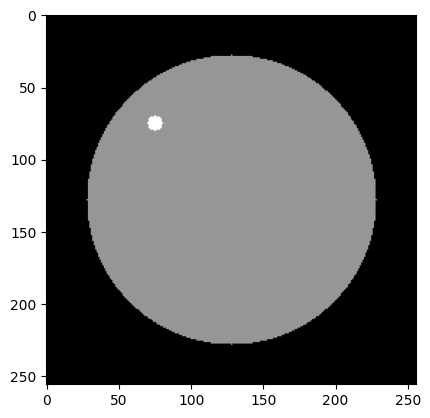

In [83]:
# Create phantom without lesion
phantom = create_circular_mask(256, 256, radius=100)
phantom = phantom.astype(int) # False = 0, True = 1

# Create lesion - size is the minimum one to allocate the circular mask
lesion = create_circular_mask(11, 11, radius=5)
lesion = lesion.astype(int) # False = 0, True = 1

# Summing up phantom + lesion we get 
phantom[70:81, 70:81] = phantom[70:81, 70:81] + lesion

plt.imshow(phantom, cmap="Greys_r", vmin=0, vmax=2)

### 2.2 Create the projections of the phantom (2 points)

Generate the projections of the previously generated phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following 2 approches:

``A``. Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.

``B``. Use different ranges of angles (i.e. 4º, 20º, 50º, 100º, 200º, 300º, 360º) equally distributed.  For instance, 100 projections are taken in a range of 100º.

``Questions``: What is the effect of increasing/decrasing the number of proyections? Can you comment on the difference between approach A and B?

In [3]:
# insert your code here


### 2.3 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann).

Then, show the original and reconstructed images of the phantom.

Explore the two approches (A and B) described previously.

In [6]:
# insert your code here


### 2.4 Compare the reconstructed signals (1 points)

Make use of the ``matplotlib`` to compare the original and reconstructed signals. In order to do so, make a single plot with the different pixel intensity profiles of the lesion (as done in 2.1). Then, discuss the results.

In [7]:
# insert your code here



### 2.5 Reconstructing noisy sinograms (2 points)

Add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your previous sinograms and reconstruct the phantom images with the different filters. Plot the reconstruction image and the intensity profile along the lession. Then, comment on the effects of the filters on the reconstructed phatom images.

In [ ]:
# insert your code here



### 2.6 Sheep logan phantom (1 point)

So far we have used a quite simple phantom with only 2 tissues. Now, repeat the prior analysis using a (slightly) more advanced head test object, the Sheep-logan phantom. Do you observe particular differences between the reconstrucction results from both phantoms? 


In [6]:
from skimage.data import shepp_logan_phantom

image = shepp_logan_phantom()

# insert your code here